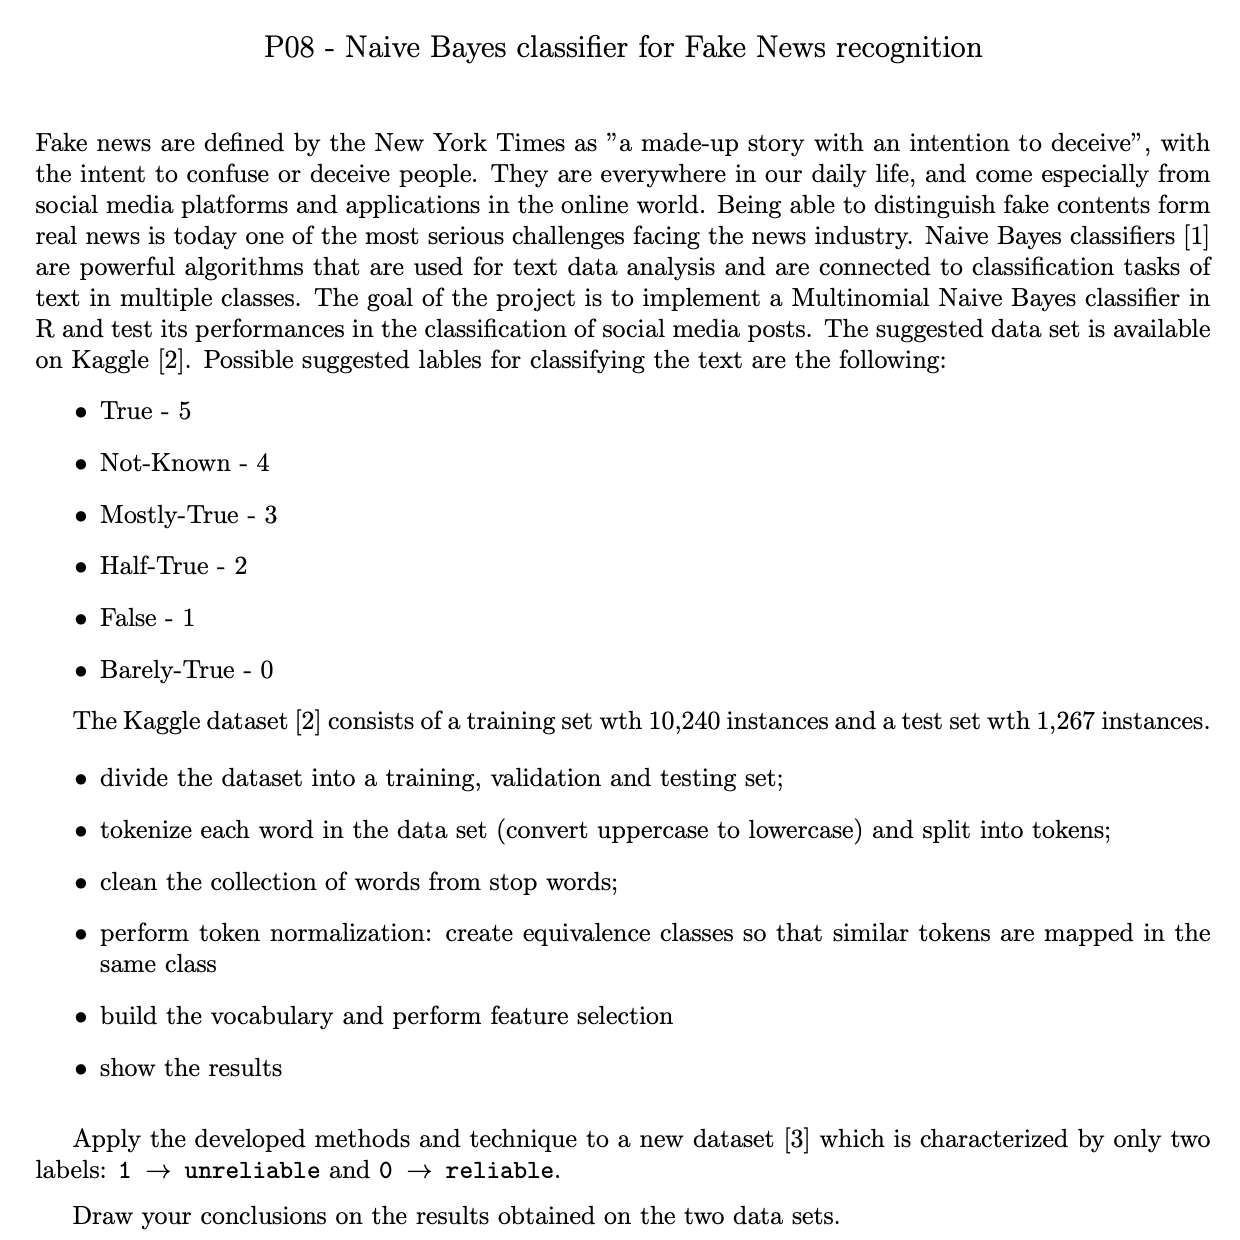

# Multinomial Naive Bayes Classifier

**Goal:** Classify a document *d* into one of *K* classes $C_k$, given its words.


## 1. Bayes' Theorem

$$
P(C_k \mid d) = \frac{P(d \mid C_k) \cdot P(C_k)}{P(d)}
$$

Since  $P(d)$ is constant across classes, we use:

$$
\arg\max_{C_k} \left[ P(d \mid C_k) \cdot P(C_k) \right]
$$


## 2. Multinomial Model

- Represent document *d* as a vector of word counts:  
- $ d = n_1, n_2, \dots, n_V $
- $V$ is the size of the vocabulary.
- $n_i$ is the number of times word $w_i$ appears in document *d*.

$$
P(d \mid C_k) = \frac{N_d!}{\prod_{i=1}^{V} n_i!} \prod_{i=1}^{V} \left( P(w_i \mid C_k) \right)^{n_i}
$$

In practice, we ignore the multinomial coefficient and compute:

$$
\log P(d \mid C_k) = \sum_{i=1}^{V} n_i \cdot \log P(w_i \mid C_k)
$$


## 3. Priors

$$
P(C_k) = \frac{\text{Number of documents in class } C_k}{\text{Total number of documents}}
$$


## 4. Likelihoods with Smoothing

$$
P(w_i \mid C_k) = \frac{N_{ik} + \alpha}{N_k + \alpha V}
$$

Where:

- $N_{ik}$ = number of times word $w_i$ occurs in documents of class $C_k$
- $N_k$ = total number of words in documents of class $C_k$
- $\alpha$ = smoothing parameter (usually $\alpha = 1$, Laplace smoothing)
- $V$ = size of vocabulary


## 5. Prediction Rule

For a given document *d*, compute for each class:

$$
\log P(C_k) + \sum_{i=1}^{V} n_i \cdot \log P(w_i \mid C_k)
$$

Choose the class with the highest score:

$$
\hat{C} = \arg\max_{C_k} \left[ \log P(C_k) + \sum_{i=1}^{V} n_i \cdot \log P(w_i \mid C_k) \right]
$$


## 6. Summary of Training Steps

1. Compute $P(C_k)$ for each class.
2. For each word $w_i$ and each class $C_k$, compute $P(w_i \mid C_k)$ with smoothing.


## 7. Summary of Prediction Steps

1. For a new document *d*, compute the score for each class.
2. Choose the class with the highest score.



---
# Load the datasets

In [1]:
# Load the required libraries
library(ggplot2)
library(tidytext)
library(dplyr)
library(tm)
library(tidyr)
library(SnowballC)
library(readr)

set.seed(42)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Zorunlu paket y"ukleniyor: NLP


Attaching package: 'NLP'


The following object is masked from 'package:ggplot2':

    annotate




In [2]:
# Load the training and testing datasets
train_data = read.csv("data/original/train.csv")
test_data = read.csv("data/original/test.csv")

In [3]:
# Divide the training dataset into training and validation set. 20% of the data will be used for validation.

set.seed(123)  # For reproducibility

train_indices = sample(1:nrow(train_data), size = 0.8 * nrow(train_data))
train_data = train_data[train_indices, ]
validation_data = train_data[-train_indices, ]

In [4]:
print("--------- Training Data Summary ---------")
summarize(train_data,
          num_rows = n(), 
          num_cols = ncol(train_data),
          num_missing = sum(is.na(train_data)))

print("--------- Validation Data Summary ---------")
summarise(validation_data,
          num_rows = n(),
          num_cols = ncol(validation_data),
          num_missing = sum(is.na(validation_data)))

print("--------- Testing Data Summary ---------")
summarise(test_data,
          num_rows = n(),
          num_cols = ncol(test_data),
          num_missing = sum(is.na(test_data)))

[1] "--------- Training Data Summary ---------"


num_rows,num_cols,num_missing
<int>,<int>,<int>
8192,3,0


[1] "--------- Validation Data Summary ---------"


num_rows,num_cols,num_missing
<int>,<int>,<int>
1612,3,0


[1] "--------- Testing Data Summary ---------"


num_rows,num_cols,num_missing
<int>,<int>,<int>
1267,2,0


In [5]:
train_data = train_data %>% mutate(doc_id = row_number())
validation_data = validation_data %>% mutate(doc_id = row_number())
test_data = test_data %>% mutate(doc_id = row_number())

In [6]:
train_data$Text = as.character(train_data$Text)
validation_data$Text = as.character(validation_data$Text)
test_data$Text = as.character(test_data$Text)

In [7]:
train_data[0:5,]

,Labels,Text,Text_Tag,doc_id
,<int>,<chr>,<chr>,<int>
2463,4,Says Wisconsin Gov. Scott Walkers budget calls for raising property taxes by nearly $500 billion.,"state-budget,taxes",1
2511,5,Californias credit rating is the worst in the country.,"economy,message-machine,state-budget",2
8718,5,Michael Thurmond authored major legislation that has provided more than $250 million in tax relief to Georgias senior citizens and working families.,taxes,3
2986,3,"Palin ""fired Wasilla's Police Chief because he 'intimidated' her.""",crime,4
1842,5,[L]ess than one-tenth of Atlantas transportation needs are covered in a referendum to levy a 1-cent sales tax.,transportation,5


### Possible labels of the data
- False: 1
- Half-True: 2
- Mostly-True: 3
- Not-Known: 4
- True: 5
- Barely-True: 0

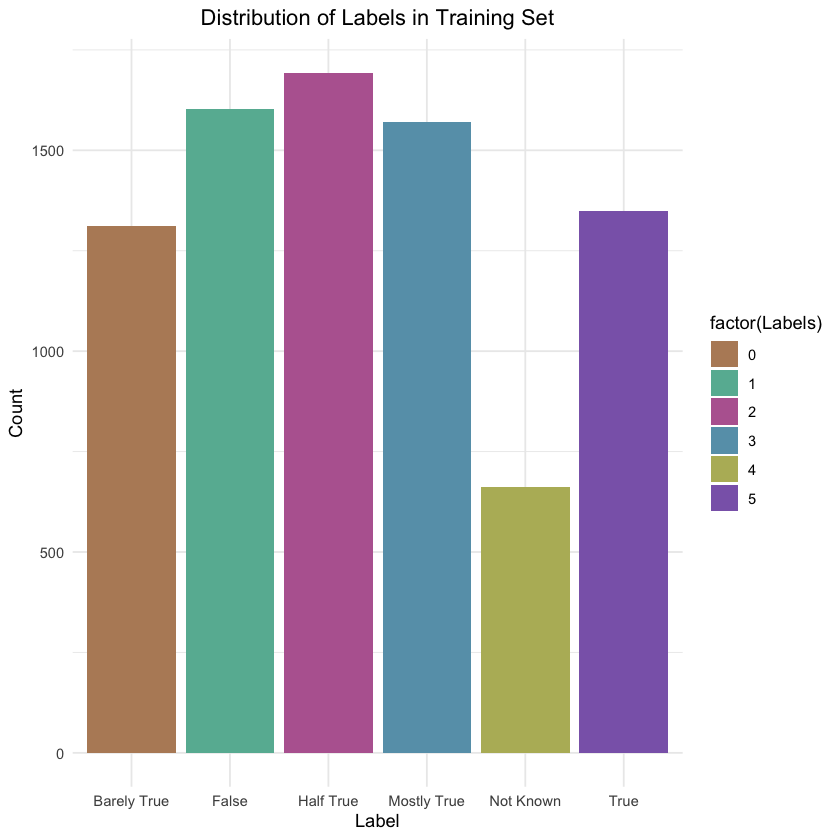

In [8]:
ggplot(train_data, aes(x = factor(Labels), fill = factor(Labels))) +
  geom_bar() +
  labs(title = "Distribution of Labels in Training Set",
       x = "Label",
       y = "Count") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5)) +
  scale_x_discrete(labels = c("0" = "Barely True", 
                               "1" = "False", 
                               "2" = "Half True", 
                               "3" = "Mostly True", 
                               "4" = "Not Known", 
                               "5" = "True")) +
  scale_fill_manual(values = c("0" = "#b78b67", 
                               "1" = "#67b7a1", 
                               "2" = "#b7679f", 
                               "3" = "#679fb7", 
                               "4" = "#b7b767", 
                               "5" = "#8b67b7"))

# Tokenization
We tokenize all of the datasets such that each datapoint will be a vector of the words it contains. All of the letters are converted into lowercase. The punctuation is removed. Stopwords such as "and", "of", or "the" are also removed. We replace numbers with a < number > placeholder unless it includes a dollar sign ($) or a percentage (%)

In [9]:
tokenize_and_clean_text <- function(data_frame, use_stemming = TRUE) {
  data_frame %>% 
    # Tokenize the text into individual words (from tidytext library)
    unnest_tokens(word, Text, drop = FALSE) %>%
    
    # Remove punctuation (uses regex to match punctuation characters)
    mutate(word = gsub("[[:punct:]]", "", word)) %>%
    
    # Replace numbers with a placeholder unless they start with $ or end with %
    mutate(word = ifelse(grepl("^\\$[0-9]+|[0-9]+%$", word), 
                         word, 
                         gsub("[[:digit:]]+", "<number>", word))) %>%
    
    # Create equivalence classes (word stemming) — only if use_stemming is TRUE
    { if (use_stemming) mutate(., word = wordStem(word, language = "en")) else . } %>%
    
    # Remove English stopwords
    anti_join(stop_words, by = "word") %>%
    
    # Filter out any empty strings
    filter(word != "") %>%
    
    # Filter out single-character words
    filter(nchar(word) > 1)
}


In [10]:
create_dtm <- function(tokenized_data, total_docs = NULL, tfidf = FALSE, tfidf_power = 1.0) {
  if (!all(c("doc_id", "word") %in% colnames(tokenized_data))) {
    stop("The data must contain 'doc_id' and 'word' columns.")
  }

  if (!is.null(total_docs)) {
    all_doc_ids <- data.frame(doc_id = 1:total_docs)
    tokenized_data <- all_doc_ids %>%
      left_join(tokenized_data, by = "doc_id") %>%
      filter(!is.na(word) & word != "")
  }

  word_counts <- tokenized_data %>%
    count(doc_id, word)

  if (tfidf) {
    # Compute TF-IDF manually
    doc_freq <- word_counts %>%
      group_by(word) %>%
      summarise(df = n_distinct(doc_id), .groups = "drop")

    total_docs <- n_distinct(word_counts$doc_id)

    tf_idf <- word_counts %>%
      left_join(doc_freq, by = "word") %>%
      mutate(
        tf = n,
        idf = log((total_docs + 1) / (df + 1)) + 1,
        tf_idf = (tf * idf) ^ tfidf_power
      )

    dtm <- tf_idf %>%
      select(doc_id, word, tf_idf) %>%
      cast_sparse(doc_id, word, tf_idf)

  } else {
    dtm <- word_counts %>%
      cast_sparse(doc_id, word, n)
  }

  return(dtm)
}


In [11]:
prepare_pipeline <- function(train_data, validation_data, test_data,
                             min_freq = 5,
                             use_text_tag = TRUE,
                             use_tfidf = TRUE,
                             tfidf_power = 1.0,
                             use_stemming = TRUE) {
  
  # 1. Optionally add Text_Tag
  if (use_text_tag) {
    train_data <- train_data %>% mutate(Text = paste(Text, Text_Tag))
    validation_data <- validation_data %>% mutate(Text = paste(Text, Text_Tag))
    test_data <- test_data %>% mutate(Text = paste(Text, Text_Tag))
  }

  # 2. Tokenize
  tokenized_train_data <- tokenize_and_clean_text(train_data, use_stemming = use_stemming)
  tokenized_validation_data <- tokenize_and_clean_text(validation_data, use_stemming = use_stemming)
  tokenized_test_data <- tokenize_and_clean_text(test_data, use_stemming = use_stemming)


  # 3. Filter low-frequency vocab
  vocab <- tokenized_train_data %>%
    count(word) %>%
    filter(n >= min_freq) %>%
    pull(word)

  tokenized_train_data <- tokenized_train_data %>% filter(word %in% vocab)
  tokenized_validation_data <- tokenized_validation_data %>% filter(word %in% vocab)
  tokenized_test_data <- tokenized_test_data %>% filter(word %in% vocab)

  # 4. Create matrices with optional TF-IDF
  training_matrix <- create_dtm(tokenized_train_data, tfidf = use_tfidf, tfidf_power = tfidf_power)
  validation_matrix <- create_dtm(tokenized_validation_data, tfidf = use_tfidf, tfidf_power = tfidf_power)
  test_matrix <- create_dtm(tokenized_test_data, total_docs = nrow(test_data), tfidf = use_tfidf, tfidf_power = tfidf_power)

  # Coerce all to numeric matrices
  training_matrix <- as.matrix(training_matrix)
  validation_matrix <- as.matrix(validation_matrix)
  test_matrix <- as.matrix(test_matrix)
  

  return(list(
    training_matrix = training_matrix,
    validation_matrix = validation_matrix,
    test_matrix = test_matrix,
    vocab = vocab,
    tokenized_train_data = tokenized_train_data
  ))
}


# Naive Bayes Classifier Main Functions

In [12]:
predict_naive_bayes <- function(matrix, priors, log_likelihoods, classes) {
  predictions <- vector("character", nrow(matrix))
  vocab <- colnames(matrix)
  
  for (i in 1:nrow(matrix)) {
    doc <- as.numeric(matrix[i, ])
    names(doc) <- colnames(matrix)  # important for word-based lookup
    scores <- sapply(classes, function(class) {
      shared_words <- intersect(vocab, names(log_likelihoods[[class]]))
      if (length(shared_words) == 0) return(-Inf)
      sum(doc[shared_words] * log_likelihoods[[class]][shared_words]) + log(priors[class])
    })
    predictions[i] <- classes[which.max(scores)]
  }
  
  return(predictions)
}

train_naive_bayes <- function(training_matrix, train_labels,
                              validation_matrix, validation_labels,
                              laplace = 1.0) {
  training_matrix <- as.matrix(training_matrix)
  validation_matrix <- as.matrix(validation_matrix)

  train_labels <- as.factor(train_labels)
  validation_labels <- as.factor(validation_labels)
  classes <- levels(train_labels)

  priors <- table(train_labels) / length(train_labels)

  likelihoods <- list()
  for (class in classes) {
    class_rows <- training_matrix[train_labels == class, , drop = FALSE]
    word_totals <- colSums(class_rows) + laplace
    likelihoods[[class]] <- word_totals / sum(word_totals)
  }

  epsilon <- 1e-10
  vocab <- colnames(training_matrix)
  log_likelihoods <- list()
  for (class in classes) {
    log_likelihoods[[class]] <- sapply(vocab, function(word) {
      if (word %in% names(likelihoods[[class]])) {
        log(likelihoods[[class]][[word]])
      } else {
        log(epsilon)
      }
    })
  }

  validation_predictions <- predict_naive_bayes(validation_matrix,
                                                priors,
                                                log_likelihoods,
                                                classes)

  confusion_matrix <- table(Predicted = validation_predictions, Actual = validation_labels)
  accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)

  print("Confusion Matrix:")
  print(confusion_matrix)
  print(paste("Validation Accuracy:", round(accuracy * 100, 2), "%"))

  return(list(
    priors = priors,
    likelihoods = likelihoods,
    log_likelihoods = log_likelihoods,
    classes = classes,
    predictions = validation_predictions,
    confusion_matrix = confusion_matrix
  ))
}


## TD-IDF and Laplace smoothing


--- tfidf_power = 0.1 ---
[1] "Confusion Matrix:"
         Actual
Predicted   0   1   2   3   4   5
        0 151  22  15  19   8   9
        1  22 184  20  24  18  31
        2  58  52 222  32  15  43
        3  27  34  34 204  13  34
        4   1   2   4   4  64   3
        5  11  23  21  15  10 163
[1] "Validation Accuracy: 61.29 %"

--- tfidf_power = 0.2 ---
[1] "Confusion Matrix:"
         Actual
Predicted   0   1   2   3   4   5
        0 157  21  17  19   8  12
        1  22 186  19  23  15  30
        2  52  50 219  30  14  38
        3  26  33  35 207  12  32
        4   1   2   5   4  70   3
        5  12  25  21  15   9 168
[1] "Validation Accuracy: 62.47 %"

--- tfidf_power = 0.3 ---
[1] "Confusion Matrix:"
         Actual
Predicted   0   1   2   3   4   5
        0 163  20  17  18   8  13
        1  19 188  16  22  12  29
        2  47  46 222  27  13  33
        3  26  34  33 209  11  29
        4   3   2   5   7  79   3
        5  12  27  23  15   5 176
[1] "Validation

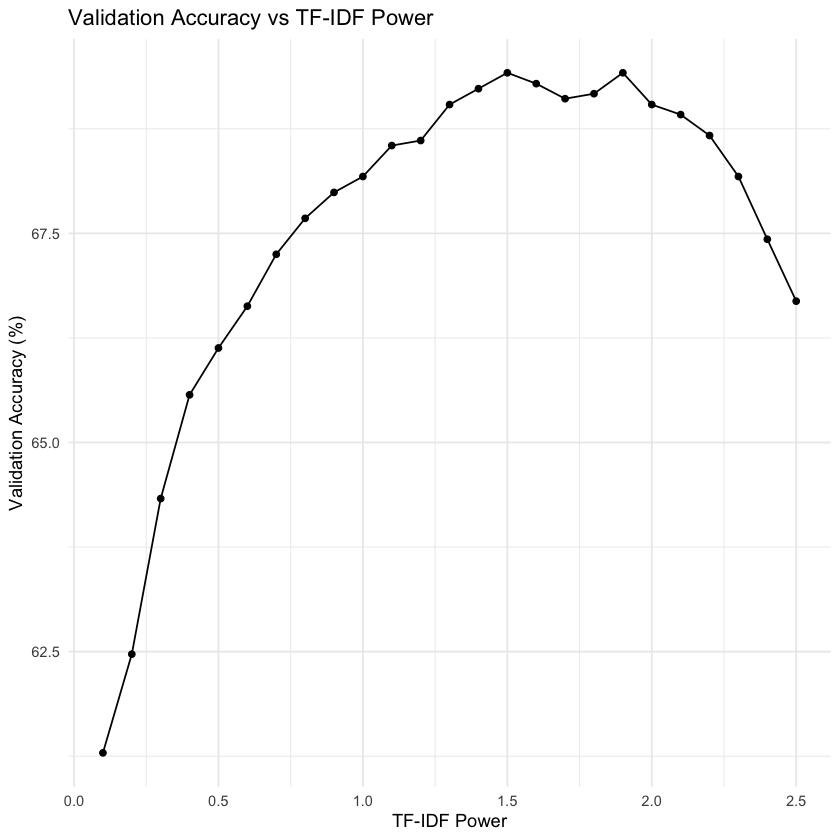

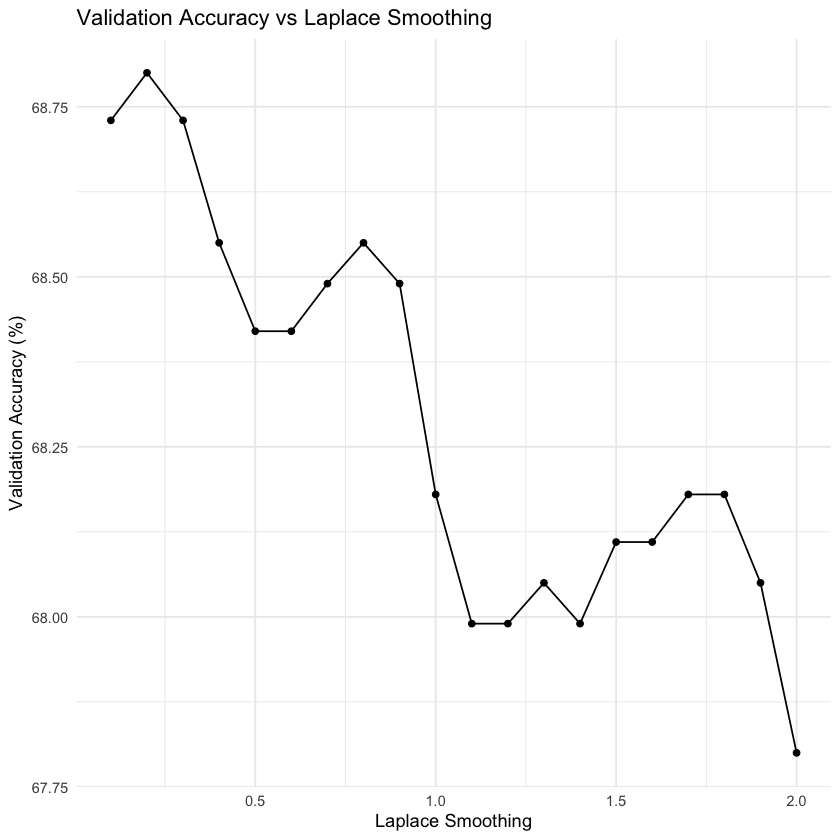

In [13]:
library(ggplot2)

# Fixed parameters
fixed_min_freq     <- 1
fixed_use_text_tag <- FALSE
fixed_use_tfidf    <- TRUE
fixed_use_stemming <- TRUE

# Values to test
# tfidf_power_values <- c(0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0)
tfidf_power_values <- seq(0.1,2.5,0.1)
# laplace_values     <- c(0.1, 0.15 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.1, 0.5, 1.0, 1.5, 2.0)
laplace_values <- seq(0, 2.0, 0.1)
 
# Store results
results_power <- data.frame(tfidf_power = numeric(), validation_accuracy = numeric())
results_laplace <- data.frame(laplace = numeric(), validation_accuracy = numeric())

# Loop for tfidf_power
for (tfidf_power in tfidf_power_values) {
  cat("\n--- tfidf_power =", tfidf_power, "---\n")
  tryCatch({
    result <- prepare_pipeline(train_data, validation_data, test_data,
                               min_freq = fixed_min_freq,
                               use_text_tag = fixed_use_text_tag,
                               use_tfidf = fixed_use_tfidf,
                               tfidf_power = tfidf_power,
                               use_stemming = fixed_use_stemming)

    train_indices <- as.integer(rownames(result$training_matrix))
    val_indices   <- as.integer(rownames(result$validation_matrix))
    train_labels_aligned <- train_data$Labels[train_indices]
    val_labels_aligned   <- validation_data$Labels[val_indices]

    model <- train_naive_bayes(result$training_matrix,
                               train_labels_aligned,
                               result$validation_matrix,
                               val_labels_aligned,
                               laplace = 1.0)

    acc <- sum(diag(model$confusion_matrix)) / sum(model$confusion_matrix)

    results_power <- rbind(results_power, data.frame(
      tfidf_power = tfidf_power,
      validation_accuracy = round(acc * 100, 2)
    ))

  }, error = function(e) {
    cat("⚠️ tfidf_power error:", e$message, "\n")
  })
}

# Loop for laplace
for (laplace in laplace_values) {
  cat("\n--- laplace =", laplace, "---\n")
  tryCatch({
    result <- prepare_pipeline(train_data, validation_data, test_data,
                               min_freq = fixed_min_freq,
                               use_text_tag = fixed_use_text_tag,
                               use_tfidf = fixed_use_tfidf,
                               tfidf_power = 1.0,
                               use_stemming = fixed_use_stemming)

    train_indices <- as.integer(rownames(result$training_matrix))
    val_indices   <- as.integer(rownames(result$validation_matrix))
    train_labels_aligned <- train_data$Labels[train_indices]
    val_labels_aligned   <- validation_data$Labels[val_indices]

    model <- train_naive_bayes(result$training_matrix,
                               train_labels_aligned,
                               result$validation_matrix,
                               val_labels_aligned,
                               laplace = laplace)

    acc <- sum(diag(model$confusion_matrix)) / sum(model$confusion_matrix)

    results_laplace <- rbind(results_laplace, data.frame(
      laplace = laplace,
      validation_accuracy = round(acc * 100, 2)
    ))

  }, error = function(e) {
    cat("⚠️ laplace error:", e$message, "\n")
  })
}

# Plot: Validation Accuracy vs tfidf_power
ggplot(results_power, aes(x = tfidf_power, y = validation_accuracy)) +
  geom_point() +
  geom_line() +
  labs(title = "Validation Accuracy vs TF-IDF Power",
       x = "TF-IDF Power", y = "Validation Accuracy (%)") +
  theme_minimal()

# Plot: Validation Accuracy vs Laplace
ggplot(results_laplace, aes(x = laplace, y = validation_accuracy)) +
  geom_point() +
  geom_line() +
  labs(title = "Validation Accuracy vs Laplace Smoothing",
       x = "Laplace Smoothing", y = "Validation Accuracy (%)") +
  theme_minimal()


# Varying hyperparameter configurations

In [14]:
# Define hyperparameter grid
min_freq_values     <- c(1, 2, 3)
use_text_tag_values <- c(TRUE, FALSE)
use_tfidf_values    <- c(TRUE, FALSE)
tfidf_power_values  <- c(0.1, 1.0, 2.0)
laplace_values      <- c(0.001, 0.01, 0.1)
use_stemming_values <- c(TRUE, FALSE)

# Create an empty data frame to store results
results <- data.frame(
  min_freq = integer(),
  use_text_tag = logical(),
  use_tfidf = logical(),
  laplace = numeric(),
  tfidf_power = numeric(),
  use_stemming = logical(),
  validation_accuracy = numeric(),
  stringsAsFactors = FALSE
)

# Initialize trackers OUTSIDE the loop
best_model <- NULL
best_result <- NULL
best_acc <- 0
best_config <- list()

# Grid search loop
for (min_freq in min_freq_values) {
  for (use_text_tag in use_text_tag_values) {
    for (use_tfidf in use_tfidf_values) {
      for (laplace in laplace_values) {
        for (tfidf_power in tfidf_power_values) {
          for (use_stemming in use_stemming_values) {

            cat("\n--- Running with:",
                "min_freq =", min_freq,
                "| use_text_tag =", use_text_tag,
                "| use_tfidf =", use_tfidf,
                "| laplace =", laplace,
                "| tfidf_power =", tfidf_power,
                "| use_stemming =", use_stemming, "---\n")

            tryCatch({

              # Prepare matrices
              result <- prepare_pipeline(train_data, validation_data, test_data,
                                         min_freq = min_freq,
                                         use_text_tag = use_text_tag,
                                         use_tfidf = use_tfidf,
                                         tfidf_power = tfidf_power,
                                         use_stemming = use_stemming)

              # Align labels
              train_indices <- as.integer(rownames(result$training_matrix))
              val_indices   <- as.integer(rownames(result$validation_matrix))

              train_labels_aligned <- train_data$Labels[train_indices]
              val_labels_aligned   <- validation_data$Labels[val_indices]

              # Train model
              model <- train_naive_bayes(result$training_matrix,
                                         train_labels_aligned,
                                         result$validation_matrix,
                                         val_labels_aligned,
                                         laplace = laplace)

              # Compute accuracy
              acc <- sum(diag(model$confusion_matrix)) / sum(model$confusion_matrix)

              # Save results
              results <- rbind(results, data.frame(
                min_freq = min_freq,
                use_text_tag = use_text_tag,
                use_tfidf = use_tfidf,
                laplace = laplace,
                tfidf_power = tfidf_power,
                use_stemming = use_stemming,
                validation_accuracy = round(acc * 100, 2)
              ))

              # Update best if applicable
              if (acc > best_acc) {
                best_acc <- acc
                best_model <- model
                best_result <- result
                best_config <- list(
                  min_freq = min_freq,
                  use_text_tag = use_text_tag,
                  use_tfidf = use_tfidf,
                  laplace = laplace,
                  tfidf_power = tfidf_power,
                  use_stemming = use_stemming
                )
              }

            }, error = function(e) {
              cat("⚠️ Skipped config due to error:", e$message, "\n")
            })
          }
        }
      }
    }
  }
}

# Print summary
cat("\nBest validation accuracy:", round(best_acc * 100, 2), "%\n")
print(best_config)

cat("Best Configuration:\n")
print(best_config)

# Save results if needed
print(results)



--- Running with: min_freq = 1 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = TRUE ---
[1] "Confusion Matrix:"
         Actual
Predicted   0   1   2   3   4   5
        0 183  28  23  17   7  13
        1  18 195  14  24   4  23
        2  32  33 225  26   4  24
        3  21  28  29 212   8  25
        4   4   7   3   4 101   5
        5  12  26  22  15   4 193
[1] "Validation Accuracy: 68.8 %"

--- Running with: min_freq = 1 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = FALSE ---
[1] "Confusion Matrix:"
         Actual
Predicted   0   1   2   3   4   5
        0 205  18  15  11   2   6
        1  16 229  11  12   2  14
        2  22  24 251  17   7  22
        3  16  20  22 241   5  22
        4   2   5   2   1 110   8
        5   9  21  15  16   2 211
[1] "Validation Accuracy: 77.36 %"

--- Running with: min_freq = 1 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_p

### Comparison of hyperparameters

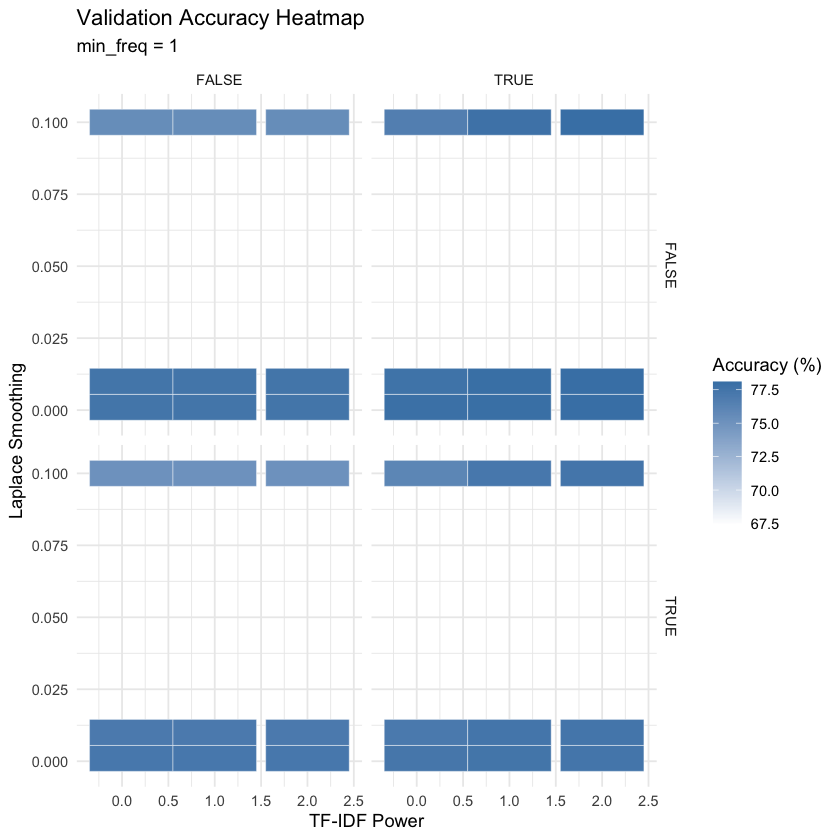

In [15]:
# Filter to a specific min_freq
subset_results <- results[results$min_freq == 1, ]

ggplot(subset_results, aes(x = tfidf_power, y = laplace, fill = validation_accuracy)) +
  geom_tile(color = "white") +
  facet_grid(use_text_tag ~ use_tfidf) +
  scale_fill_gradient(low = "white", high = "steelblue") +
  labs(
    title = "Validation Accuracy Heatmap",
    subtitle = "min_freq = 1",
    x = "TF-IDF Power",
    y = "Laplace Smoothing",
    fill = "Accuracy (%)"
  ) +
  theme_minimal()


## Confusion matrix of the best model

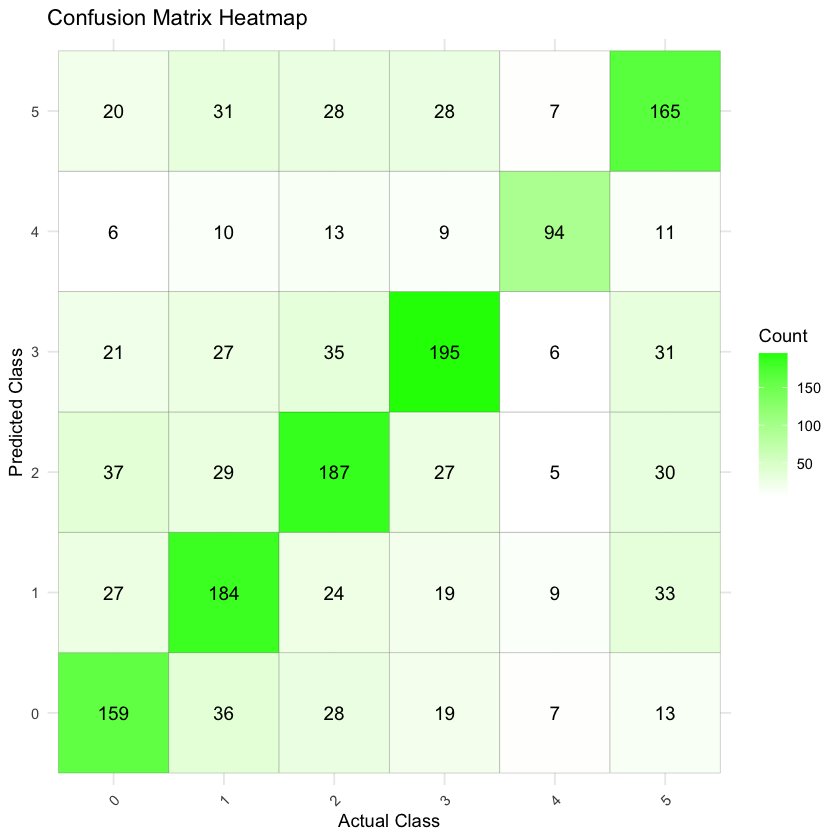

In [16]:
confusion_matrix = model$confusion_matrix

cm_df <- as.data.frame(confusion_matrix)
colnames(cm_df) <- c("Predicted", "Actual", "Count")

ggplot(cm_df, aes(x = Actual, y = Predicted, fill = Count)) +
  geom_tile(color = "black", linewidth = 0.05) +
  geom_text(aes(label = Count), color = "black", size = 4) +
  scale_fill_gradient(low = "white", high = "green") +
  theme_minimal() +
  labs(title = "Confusion Matrix Heatmap",
       x = "Actual Class",
       y = "Predicted Class") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


# Test evaluation

In [17]:
test_indices <- as.integer(rownames(best_result$test_matrix))
test_texts <- test_data$Text[test_indices]

# Predict on test
test_predictions <- predict_naive_bayes(
  best_result$test_matrix,
  best_model$priors,
  best_model$log_likelihoods,
  names(best_model$priors)
)

# Save predictions (optional)
head(test_predictions)

print("🏁 Best Config:")
print(best_config)




[1] "2" "3" "4" "1" "1" "5"

[1] "<U+0001F3C1> Best Config:"
$min_freq
[1] 1

$use_text_tag
[1] FALSE

$use_tfidf
[1] TRUE

$laplace
[1] 0.001

$tfidf_power
[1] 2

$use_stemming
[1] FALSE



In [18]:
table(test_predictions)

test_predictions
  0   1   2   3   4   5 
221 198 273 251 113 210 

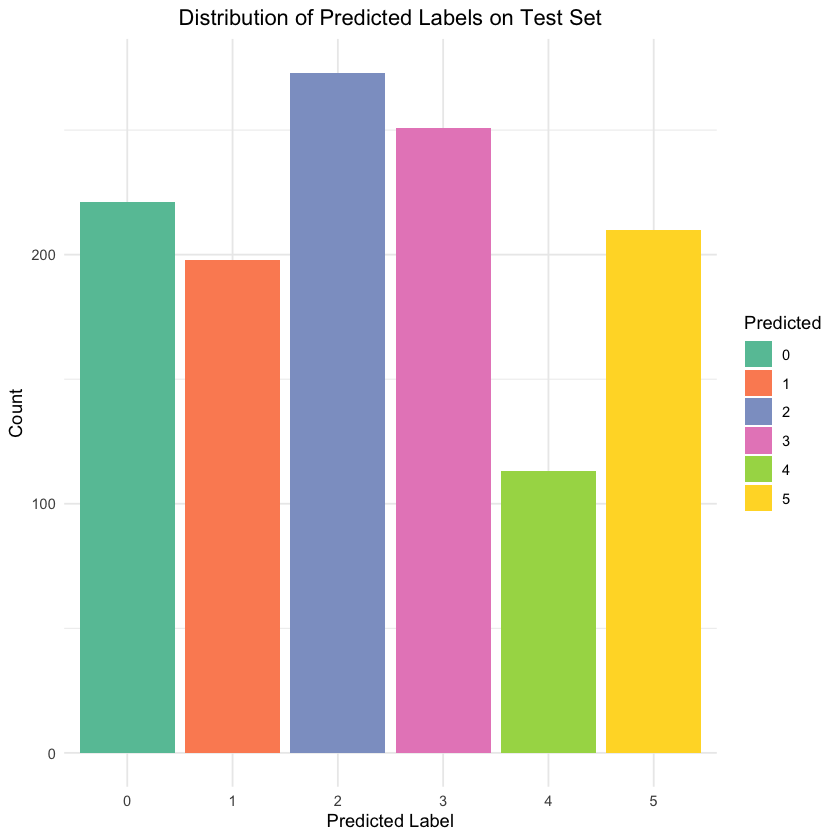

In [19]:
# Convert to data frame
pred_df <- data.frame(Predicted = test_predictions)

# Plot
ggplot(pred_df, aes(x = Predicted, fill = Predicted)) +
  geom_bar() +
  labs(title = "Distribution of Predicted Labels on Test Set",
       x = "Predicted Label",
       y = "Count") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5)) +
  scale_fill_brewer(palette = "Set2")


In [20]:
label_names <- c(
  "Barely-True",  # 0
  "False",        # 1
  "Half-True",    # 2
  "Mostly-True",  # 3
  "Not-Known",    # 4
  "True"          # 5
)

# Safely match rownames of test_matrix back to test_data
test_doc_ids <- as.integer(rownames(best_result$test_matrix))
row_matches <- match(test_doc_ids, test_data$doc_id)

# Ensure valid rows
valid_rows <- !is.na(row_matches)
test_doc_ids <- test_doc_ids[valid_rows]
row_matches <- row_matches[valid_rows]

# Get aligned test data
test_df <- test_data[row_matches, ]

# Coerce to integer before indexing
predicted_numeric <- as.integer(test_predictions[valid_rows])

# Construct the result table
results_table <- data.frame(
  doc_id = test_doc_ids,
  Text = test_df$Text,
  Text_Tag = test_df$Text_Tag,
  Predicted_Label = predicted_numeric,
  Predicted_Label_Name = label_names[predicted_numeric + 1]
)


# View
results_table[0:30,]


,doc_id,Text,Text_Tag,Predicted_Label,Predicted_Label_Name
,<int>,<chr>,<chr>,<int>,<chr>
1,1,Building a wall on the U.S.-Mexico border will take literally years.,immigration,2,Half-True
2,2,Wisconsin is on pace to double the number of layoffs this year.,jobs,3,Mostly-True
3,3,Says John McCain has done nothing to help the vets.,"military,veterans,voting-record",4,Not-Known
4,4,Suzanne Bonamici supports a plan that will cut choice for Medicare Advantage seniors.,"medicare,message-machine-2012,campaign-advertising",1,False
5,5,"When asked by a reporter whether hes at the center of a criminal scheme to violate campaign laws, Gov. Scott Walker nodded yes.","campaign-finance,legal-issues,campaign-advertising",1,False
6,6,Over the past five years the federal government has paid out $601 million in retirement and disability benefits to deceased former federal employees.,"federal-budget,pensions,retirement",5,True
7,7,Says that Tennessee law requires that schools receive half of proceeds -- $31 million per year -- from a half-cent increase in the Shelby County sales tax.,"county-budget,county-government,education,taxes",1,False
8,8,"Says Vice President Joe Biden ""admits that the American people are being scammed"" with the economic stimulus package.","economy,stimulus",0,Barely-True
9,9,Donald Trump is against marriage equality. He wants to go back.,"gays-and-lesbians,marriage",3,Mostly-True


# Binary classification

In [21]:
fake_data <- read.csv("data/binary/News_dataset/Fake.csv", stringsAsFactors = FALSE)
real_data <- read.csv("data/binary/News_dataset/True.csv", stringsAsFactors = FALSE)

In [22]:
fake_data$label <- 0  # 0 FOR FAKE
real_data$label <- 1  # 1 FOR REAL

binary_data <- rbind(fake_data, real_data)

set.seed(42)
binary_data <- binary_data[sample(nrow(binary_data)), ]

binary_data_clean <- binary_data[, c("title", "subject", "label")]
colnames(binary_data_clean) <- c("Text", "Text_Tag", "Labels")

We only include true, mostly-true, false, and pants-fire as labels to convert for avoiding overlap between more uncertain labels. This helps our labels to have more certainty.

In [23]:
set.seed(42)

# PROPORTIONS: 80% TRAIN, 10% VALIDATION, 10% TEST
n <- nrow(binary_data_clean)
binary_train_index <- 1:floor(0.8 * n)
binary_val_index   <- (max(binary_train_index) + 1):(max(binary_train_index) + floor(0.1 * n))
binary_test_index  <- (max(binary_val_index) + 1):n

# CREATING SPLITS
binary_train_data      <- binary_data_clean[binary_train_index, ]
binary_validation_data <- binary_data_clean[binary_val_index, ]
binary_test_data       <- binary_data_clean[binary_test_index, ]

# ASSIGNING DOC_IDS FOR DTM CREATION
binary_train_data$doc_id      <- 1:nrow(binary_train_data)
binary_validation_data$doc_id <- 1:nrow(binary_validation_data)
binary_test_data$doc_id       <- 1:nrow(binary_test_data)


In [24]:
table(binary_data_clean$Label)


    0     1 
23481 21417 

In [25]:
# Safer Text Normalization
clean_text_column <- function(text) {
  text <- iconv(text, from = "", to = "UTF-8", sub = " ")           # Replace invalid bytes
  text <- gsub("[^[:print:]]", " ", text)                            # Remove non-printable chars
  text <- gsub("\\s+", " ", text)                                   # Normalize whitespace
  text <- trimws(text)                                              # Trim spaces
  return(text)
}

# Apply it safely
binary_data_clean$Text <- clean_text_column(binary_data_clean$Text)


In [26]:
binary_data_clean

,Text,Text_Tag,Labels
,<chr>,<chr>,<dbl>
34020,Florida Gov. Scott not endorsing 2016 Republican presidential candidate,politicsNews,1
8826,Fox News Host Calls For American Muslims With Links To ISIS To Be Executed Without Trial (VIDEO),News,0
16740,WHAT S SO WRONG WITH TRANSGENDER BATHROOMS? This Guy Has The Awesome Answer!,Government News,0
7700,Highly Ranked Draft Prospect Asked By NFL Coach If He Was Gay During Meeting,News,0
36722,Saudi-led air strikes support Yemen's Saleh as he shifts against Houthis,worldnews,1
9091,U2 s LIMOUSINE LIBERAL BONO Proves He s Clueless On Trump: Bleakest Era,politics,0
33700,House Speaker Ryan attacks Obama trip to Cuba,politicsNews,1
13610,BOOM! MEXICAN AMERICAN TRUMP Supporter Explains Difference Between ILLEGAL And LEGAL Citizens: She (Hillary) Is A Criminal [VIDEO],politics,0
40094,Catalan government to appeal direct rule in constitutional court,worldnews,1


## Grid search on dataset 2 (LIAR)

In [27]:
# Define hyperparameter grid
binary_min_freq_values     <- c(2,3,4) # KEEP THIS ABOVE 2. OTHERWISE R MEMORY OVERLOADS
binary_use_text_tag_values <- c(TRUE, FALSE)
binary_use_tfidf_values    <- c(TRUE, FALSE)
binary_tfidf_power_values  <- c(0.1, 1.0, 1.6)
binary_laplace_values      <- c(0.001, 0.01, 0.1)
binary_use_stemming_values <- c(TRUE, FALSE)

# Results storage
binary_results <- data.frame(
  min_freq = integer(),
  use_text_tag = logical(),
  use_tfidf = logical(),
  laplace = numeric(),
  tfidf_power = numeric(),
  use_stemming = logical(),
  validation_accuracy = numeric(),
  stringsAsFactors = FALSE
)

# Track best model/config
binary_best_model   <- NULL
binary_best_result  <- NULL
binary_best_acc     <- 0
binary_best_config  <- list()

# Grid search loop
for (min_freq in binary_min_freq_values) {
  for (use_text_tag in binary_use_text_tag_values) {
    for (use_tfidf in binary_use_tfidf_values) {
      for (laplace in binary_laplace_values) {
        for (tfidf_power in binary_tfidf_power_values) {
          for (use_stemming in binary_use_stemming_values) {

            cat("\n--- Binary config:",
                "min_freq =", min_freq,
                "| use_text_tag =", use_text_tag,
                "| use_tfidf =", use_tfidf,
                "| laplace =", laplace,
                "| tfidf_power =", tfidf_power,
                "| use_stemming =", use_stemming, "---\n")

            tryCatch({

              # Prepare data
              binary_result <- prepare_pipeline(
                binary_train_data, binary_validation_data, binary_test_data,
                min_freq = min_freq,
                use_text_tag = use_text_tag,
                use_tfidf = use_tfidf,
                tfidf_power = tfidf_power,
                use_stemming = use_stemming
              )

              # Align labels
              train_idx <- as.integer(rownames(binary_result$training_matrix))
              val_idx   <- as.integer(rownames(binary_result$validation_matrix))

              train_labels <- binary_train_data$Labels[train_idx]
              val_labels   <- binary_validation_data$Labels[val_idx]

              # Train model
              binary_model <- train_naive_bayes(
                binary_result$training_matrix,
                train_labels,
                binary_result$validation_matrix,
                val_labels,
                laplace = laplace
              )

              # Accuracy
              binary_acc <- sum(diag(binary_model$confusion_matrix)) / sum(binary_model$confusion_matrix)

              # Save run
              binary_results <- rbind(binary_results, data.frame(
                min_freq = min_freq,
                use_text_tag = use_text_tag,
                use_tfidf = use_tfidf,
                laplace = laplace,
                tfidf_power = tfidf_power,
                use_stemming = use_stemming,
                validation_accuracy = round(binary_acc * 100, 2)
              ))

              # Save best
              if (binary_acc > binary_best_acc) {
                binary_best_acc     <- binary_acc
                binary_best_model   <- binary_model
                binary_best_result  <- binary_result
                binary_best_config  <- list(
                  min_freq = min_freq,
                  use_text_tag = use_text_tag,
                  use_tfidf = use_tfidf,
                  laplace = laplace,
                  tfidf_power = tfidf_power,
                  use_stemming = use_stemming
                )
              }

            }, error = function(e) {
              cat("⚠️ Skipped due to error:", e$message, "\n")
            })
          }
        }
      }
    }
  }
}

# Results summary
cat("\n🏆 Best Validation Accuracy:", round(binary_best_acc * 100, 2), "%\n")
cat("🔧 Best Configuration:\n")
print(binary_best_config)

# Print all results
print(binary_results)



--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2318    3
        1   28 2140
[1] "Validation Accuracy: 99.31 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2317    4
        1   29 2139
[1] "Validation Accuracy: 99.26 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2292   71
        1   54 2072
[1] "Validation Accuracy: 97.22 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2287   78
        1   59 2065
[1] "Validation Accuracy: 96.95 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2272  104
        1   74 2039
[1] "Validation Accuracy: 96.03 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2268  119
        1   78 2024
[1] "Validation Accuracy: 95.61 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2319    2
        1   27 2141
[1] "Validation Accuracy: 99.35 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2318    3
        1   28 2140
[1] "Validation Accuracy: 99.31 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2293   60
        1   53 2083
[1] "Validation Accuracy: 97.48 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2293   62
        1   53 2081
[1] "Validation Accuracy: 97.44 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2274  106
        1   72 2037
[1] "Validation Accuracy: 96.03 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2270  117
        1   76 2026
[1] "Validation Accuracy: 95.7 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2319    1
        1   27 2142
[1] "Validation Accuracy: 99.38 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2318    2
        1   28 2141
[1] "Validation Accuracy: 99.33 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2294   53
        1   52 2090
[1] "Validation Accuracy: 97.66 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2294   52
        1   52 2091
[1] "Validation Accuracy: 97.68 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2272  109
        1   74 2034
[1] "Validation Accuracy: 95.92 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2273  115
        1   73 2028
[1] "Validation Accuracy: 95.81 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2323    1
        1   23 2142
[1] "Validation Accuracy: 99.47 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2319    3
        1   27 2140
[1] "Validation Accuracy: 99.33 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2323    1
        1   23 2142
[1] "Validation Accuracy: 99.47 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2319    3
        1   27 2140
[1] "Validation Accuracy: 99.33 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2323    1
        1   23 2142
[1] "Validation Accuracy: 99.47 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2319    3
        1   27 2140
[1] "Validation Accuracy: 99.33 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2325    1
        1   21 2142
[1] "Validation Accuracy: 99.51 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2320    2
        1   26 2141
[1] "Validation Accuracy: 99.38 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2325    1
        1   21 2142
[1] "Validation Accuracy: 99.51 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2320    2
        1   26 2141
[1] "Validation Accuracy: 99.38 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2325    1
        1   21 2142
[1] "Validation Accuracy: 99.51 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2320    2
        1   26 2141
[1] "Validation Accuracy: 99.38 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2325    1
        1   21 2142
[1] "Validation Accuracy: 99.51 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2321    1
        1   25 2142
[1] "Validation Accuracy: 99.42 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2325    1
        1   21 2142
[1] "Validation Accuracy: 99.51 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2321    1
        1   25 2142
[1] "Validation Accuracy: 99.42 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2325    1
        1   21 2142
[1] "Validation Accuracy: 99.51 %"

--- Binary config: min_freq = 2 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2321    1
        1   25 2142
[1] "Validation Accuracy: 99.42 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2249  184
        1   97 1959
[1] "Validation Accuracy: 93.74 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2260  178
        1   86 1965
[1] "Validation Accuracy: 94.12 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2246  202
        1  100 1941
[1] "Validation Accuracy: 93.27 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2243  190
        1  103 1953
[1] "Validation Accuracy: 93.47 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2232  205
        1  114 1938
[1] "Validation Accuracy: 92.89 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2236  199
        1  110 1944
[1] "Validation Accuracy: 93.12 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2252  179
        1   94 1964
[1] "Validation Accuracy: 93.92 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2261  167
        1   85 1976
[1] "Validation Accuracy: 94.39 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2246  198
        1  100 1945
[1] "Validation Accuracy: 93.36 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2242  187
        1  104 1956
[1] "Validation Accuracy: 93.52 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2233  204
        1  113 1939
[1] "Validation Accuracy: 92.94 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2237  195
        1  109 1948
[1] "Validation Accuracy: 93.23 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2247  166
        1   99 1977
[1] "Validation Accuracy: 94.1 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2255  148
        1   91 1995
[1] "Validation Accuracy: 94.68 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2244  194
        1  102 1949
[1] "Validation Accuracy: 93.41 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2248  174
        1   98 1969
[1] "Validation Accuracy: 93.94 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2235  199
        1  111 1944
[1] "Validation Accuracy: 93.09 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2237  191
        1  109 1952
[1] "Validation Accuracy: 93.32 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2248  181
        1   98 1962
[1] "Validation Accuracy: 93.78 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2257  176
        1   89 1967
[1] "Validation Accuracy: 94.1 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2248  181
        1   98 1962
[1] "Validation Accuracy: 93.78 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2257  176
        1   89 1967
[1] "Validation Accuracy: 94.1 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2248  181
        1   98 1962
[1] "Validation Accuracy: 93.78 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2257  176
        1   89 1967
[1] "Validation Accuracy: 94.1 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2249  175
        1   97 1968
[1] "Validation Accuracy: 93.94 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2260  163
        1   86 1980
[1] "Validation Accuracy: 94.45 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2249  175
        1   97 1968
[1] "Validation Accuracy: 93.94 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2260  163
        1   86 1980
[1] "Validation Accuracy: 94.45 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2249  175
        1   97 1968
[1] "Validation Accuracy: 93.94 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2260  163
        1   86 1980
[1] "Validation Accuracy: 94.45 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2243  158
        1  103 1985
[1] "Validation Accuracy: 94.19 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2253  149
        1   93 1994
[1] "Validation Accuracy: 94.61 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2243  158
        1  103 1985
[1] "Validation Accuracy: 94.19 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2253  149
        1   93 1994
[1] "Validation Accuracy: 94.61 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.4 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2243  158
        1  103 1985
[1] "Validation Accuracy: 94.19 %"

--- Binary config: min_freq = 2 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.6 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2253  149
        1   93 1994
[1] "Validation Accuracy: 94.61 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2318    3
        1   28 2140
[1] "Validation Accuracy: 99.31 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2316    4
        1   30 2139
[1] "Validation Accuracy: 99.24 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2292   60
        1   54 2083
[1] "Validation Accuracy: 97.46 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2285   66
        1   61 2077
[1] "Validation Accuracy: 97.17 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2274   90
        1   72 2053
[1] "Validation Accuracy: 96.39 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2268  105
        1   78 2038
[1] "Validation Accuracy: 95.92 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2319    2
        1   27 2141
[1] "Validation Accuracy: 99.35 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2317    2
        1   29 2141
[1] "Validation Accuracy: 99.31 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2293   53
        1   53 2090
[1] "Validation Accuracy: 97.64 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2288   58
        1   58 2085
[1] "Validation Accuracy: 97.42 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2274   94
        1   72 2049
[1] "Validation Accuracy: 96.3 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2268  104
        1   78 2039
[1] "Validation Accuracy: 95.95 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2318    1
        1   28 2142
[1] "Validation Accuracy: 99.35 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2317    1
        1   29 2142
[1] "Validation Accuracy: 99.33 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2294   47
        1   52 2096
[1] "Validation Accuracy: 97.79 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2289   49
        1   57 2094
[1] "Validation Accuracy: 97.64 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2272  100
        1   74 2043
[1] "Validation Accuracy: 96.12 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2270  108
        1   76 2035
[1] "Validation Accuracy: 95.9 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2323    1
        1   23 2142
[1] "Validation Accuracy: 99.47 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2319    3
        1   27 2140
[1] "Validation Accuracy: 99.33 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2323    1
        1   23 2142
[1] "Validation Accuracy: 99.47 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2319    3
        1   27 2140
[1] "Validation Accuracy: 99.33 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2323    1
        1   23 2142
[1] "Validation Accuracy: 99.47 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2319    3
        1   27 2140
[1] "Validation Accuracy: 99.33 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2324    1
        1   22 2142
[1] "Validation Accuracy: 99.49 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2320    1
        1   26 2142
[1] "Validation Accuracy: 99.4 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2324    1
        1   22 2142
[1] "Validation Accuracy: 99.49 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2320    1
        1   26 2142
[1] "Validation Accuracy: 99.4 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2324    1
        1   22 2142
[1] "Validation Accuracy: 99.49 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2320    1
        1   26 2142
[1] "Validation Accuracy: 99.4 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2325    1
        1   21 2142
[1] "Validation Accuracy: 99.51 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2322    1
        1   24 2142
[1] "Validation Accuracy: 99.44 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2325    1
        1   21 2142
[1] "Validation Accuracy: 99.51 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2322    1
        1   24 2142
[1] "Validation Accuracy: 99.44 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2325    1
        1   21 2142
[1] "Validation Accuracy: 99.51 %"

--- Binary config: min_freq = 3 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2322    1
        1   24 2142
[1] "Validation Accuracy: 99.44 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2249  178
        1   97 1965
[1] "Validation Accuracy: 93.87 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2253  169
        1   93 1974
[1] "Validation Accuracy: 94.16 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2244  195
        1  102 1948
[1] "Validation Accuracy: 93.38 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2238  183
        1  108 1960
[1] "Validation Accuracy: 93.52 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2234  200
        1  112 1943
[1] "Validation Accuracy: 93.05 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2234  191
        1  112 1952
[1] "Validation Accuracy: 93.25 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2250  177
        1   96 1966
[1] "Validation Accuracy: 93.92 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2254  164
        1   92 1979
[1] "Validation Accuracy: 94.3 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2244  193
        1  102 1950
[1] "Validation Accuracy: 93.43 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2237  180
        1  109 1963
[1] "Validation Accuracy: 93.56 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2233  199
        1  113 1944
[1] "Validation Accuracy: 93.05 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2233  188
        1  113 1955
[1] "Validation Accuracy: 93.29 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2247  166
        1   99 1977
[1] "Validation Accuracy: 94.1 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2248  150
        1   98 1993
[1] "Validation Accuracy: 94.48 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2242  190
        1  104 1953
[1] "Validation Accuracy: 93.45 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2242  171
        1  104 1972
[1] "Validation Accuracy: 93.87 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2233  196
        1  113 1947
[1] "Validation Accuracy: 93.12 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2232  185
        1  114 1958
[1] "Validation Accuracy: 93.34 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2248  177
        1   98 1966
[1] "Validation Accuracy: 93.87 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2251  169
        1   95 1974
[1] "Validation Accuracy: 94.12 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2248  177
        1   98 1966
[1] "Validation Accuracy: 93.87 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2251  169
        1   95 1974
[1] "Validation Accuracy: 94.12 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2248  177
        1   98 1966
[1] "Validation Accuracy: 93.87 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2251  169
        1   95 1974
[1] "Validation Accuracy: 94.12 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2248  174
        1   98 1969
[1] "Validation Accuracy: 93.94 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2252  161
        1   94 1982
[1] "Validation Accuracy: 94.32 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2248  174
        1   98 1969
[1] "Validation Accuracy: 93.94 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2252  161
        1   94 1982
[1] "Validation Accuracy: 94.32 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2248  174
        1   98 1969
[1] "Validation Accuracy: 93.94 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2252  161
        1   94 1982
[1] "Validation Accuracy: 94.32 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2243  162
        1  103 1981
[1] "Validation Accuracy: 94.1 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2247  151
        1   99 1992
[1] "Validation Accuracy: 94.43 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2243  162
        1  103 1981
[1] "Validation Accuracy: 94.1 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2247  151
        1   99 1992
[1] "Validation Accuracy: 94.43 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2243  162
        1  103 1981
[1] "Validation Accuracy: 94.1 %"

--- Binary config: min_freq = 3 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.8 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2247  151
        1   99 1992
[1] "Validation Accuracy: 94.43 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2319    3
        1   27 2140
[1] "Validation Accuracy: 99.33 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2322    4
        1   24 2139
[1] "Validation Accuracy: 99.38 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2290   55
        1   56 2088
[1] "Validation Accuracy: 97.53 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2285   58
        1   61 2085
[1] "Validation Accuracy: 97.35 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2273   84
        1   73 2059
[1] "Validation Accuracy: 96.5 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2265   95
        1   81 2048
[1] "Validation Accuracy: 96.08 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2320    1
        1   26 2142
[1] "Validation Accuracy: 99.4 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2321    2
        1   25 2141
[1] "Validation Accuracy: 99.4 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2291   49
        1   55 2094
[1] "Validation Accuracy: 97.68 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2286   53
        1   60 2090
[1] "Validation Accuracy: 97.48 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2273   89
        1   73 2054
[1] "Validation Accuracy: 96.39 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2266   94
        1   80 2049
[1] "Validation Accuracy: 96.12 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2319    1
        1   27 2142
[1] "Validation Accuracy: 99.38 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2321    1
        1   25 2142
[1] "Validation Accuracy: 99.42 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2291   46
        1   55 2097
[1] "Validation Accuracy: 97.75 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2288   49
        1   58 2094
[1] "Validation Accuracy: 97.62 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2270   95
        1   76 2048
[1] "Validation Accuracy: 96.19 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2267   98
        1   79 2045
[1] "Validation Accuracy: 96.06 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2325    1
        1   21 2142
[1] "Validation Accuracy: 99.51 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2324    3
        1   22 2140
[1] "Validation Accuracy: 99.44 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2325    1
        1   21 2142
[1] "Validation Accuracy: 99.51 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2324    3
        1   22 2140
[1] "Validation Accuracy: 99.44 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2325    1
        1   21 2142
[1] "Validation Accuracy: 99.51 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2324    3
        1   22 2140
[1] "Validation Accuracy: 99.44 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2325    1
        1   21 2142
[1] "Validation Accuracy: 99.51 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2324    1
        1   22 2142
[1] "Validation Accuracy: 99.49 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2325    1
        1   21 2142
[1] "Validation Accuracy: 99.51 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2324    1
        1   22 2142
[1] "Validation Accuracy: 99.49 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2325    1
        1   21 2142
[1] "Validation Accuracy: 99.51 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2324    1
        1   22 2142
[1] "Validation Accuracy: 99.49 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2325    1
        1   21 2142
[1] "Validation Accuracy: 99.51 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2324    1
        1   22 2142
[1] "Validation Accuracy: 99.49 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2325    1
        1   21 2142
[1] "Validation Accuracy: 99.51 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2324    1
        1   22 2142
[1] "Validation Accuracy: 99.49 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2325    1
        1   21 2142
[1] "Validation Accuracy: 99.51 %"

--- Binary config: min_freq = 4 | use_text_tag = TRUE | use_tfidf = FALSE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2324    1
        1   22 2142
[1] "Validation Accuracy: 99.49 %"

--- Binary config: min_freq = 4 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2244  175
        1  102 1968
[1] "Validation Accuracy: 93.83 %"

--- Binary config: min_freq = 4 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2245  163
        1  101 1980
[1] "Validation Accuracy: 94.12 %"

--- Binary config: min_freq = 4 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2239  192
        1  107 1951
[1] "Validation Accuracy: 93.34 %"

--- Binary config: min_freq = 4 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2233  177
        1  113 1966
[1] "Validation Accuracy: 93.54 %"

--- Binary config: min_freq = 4 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2228  198
        1  118 1945
[1] "Validation Accuracy: 92.96 %"

--- Binary config: min_freq = 4 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.001 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2229  183
        1  117 1960
[1] "Validation Accuracy: 93.32 %"

--- Binary config: min_freq = 4 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2246  174
        1  100 1969
[1] "Validation Accuracy: 93.9 %"

--- Binary config: min_freq = 4 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2247  161
        1   99 1982
[1] "Validation Accuracy: 94.21 %"

--- Binary config: min_freq = 4 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2239  190
        1  107 1953
[1] "Validation Accuracy: 93.38 %"

--- Binary config: min_freq = 4 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2232  173
        1  114 1970
[1] "Validation Accuracy: 93.61 %"

--- Binary config: min_freq = 4 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2228  197
        1  118 1946
[1] "Validation Accuracy: 92.98 %"

--- Binary config: min_freq = 4 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2230  182
        1  116 1961
[1] "Validation Accuracy: 93.36 %"

--- Binary config: min_freq = 4 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2241  165
        1  105 1978
[1] "Validation Accuracy: 93.99 %"

--- Binary config: min_freq = 4 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 0.1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2241  151
        1  105 1992
[1] "Validation Accuracy: 94.3 %"

--- Binary config: min_freq = 4 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2238  188
        1  108 1955
[1] "Validation Accuracy: 93.41 %"

--- Binary config: min_freq = 4 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2236  166
        1  110 1977
[1] "Validation Accuracy: 93.85 %"

--- Binary config: min_freq = 4 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2227  194
        1  119 1949
[1] "Validation Accuracy: 93.03 %"

--- Binary config: min_freq = 4 | use_text_tag = FALSE | use_tfidf = TRUE | laplace = 0.1 | tfidf_power = 1.6 | use_stemming = FALSE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


[1] "Confusion Matrix:"
         Actual
Predicted    0    1
        0 2229  180
        1  117 1963
[1] "Validation Accuracy: 93.38 %"

--- Binary config: min_freq = 4 | use_text_tag = FALSE | use_tfidf = FALSE | laplace = 0.001 | tfidf_power = 0.1 | use_stemming = TRUE ---


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"


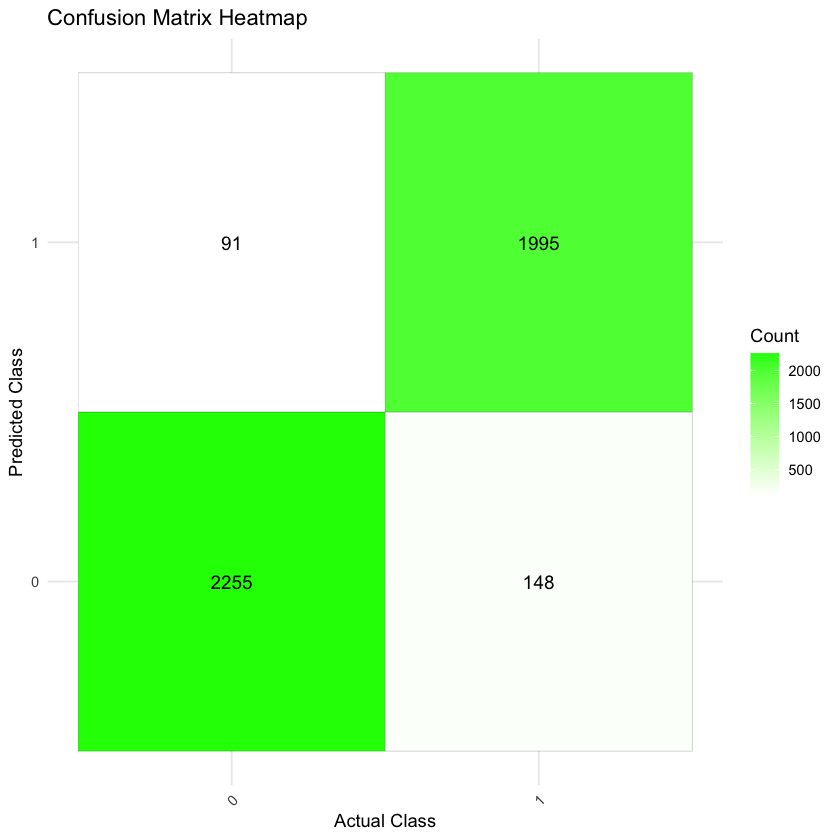

In [26]:
confusion_matrix <- binary_best_model$confusion_matrix

cm_df <- as.data.frame(confusion_matrix)
colnames(cm_df) <- c("Predicted", "Actual", "Count")

ggplot(cm_df, aes(x = Actual, y = Predicted, fill = Count)) +
  geom_tile(color = "black", linewidth = 0.05) +
  geom_text(aes(label = Count), color = "black", size = 4) +
  scale_fill_gradient(low = "white", high = "green") +
  theme_minimal() +
  labs(title = "Confusion Matrix Heatmap",
       x = "Actual Class",
       y = "Predicted Class") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [37]:
head(results_table[results_table$Predicted_Label != results_table$True_Label, ])

doc_id,Text,Text_Tag,Predicted_Label,Predicted_Label_Name
<int>,<chr>,<chr>,<int>,<chr>


In [27]:
test_indices <- as.integer(rownames(binary_mo$test_matrix))
test_texts <- test_data$Text[test_indices]

# Predict on test
test_predictions <- predict_naive_bayes(
  best_result$test_matrix,
  best_model$priors,
  best_model$log_likelihoods,
  names(best_model$priors)
)

# Save predictions (optional)
head(test_predictions)

print("🏁 Best Config:")
print(best_config)

ERROR: Error: 'best_result' nesnesi bulunamadi
